<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Download the files '''
'''Only for colab'''
useColab = True
useDrive = True

if useColab:
    !wget https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/main.zip
    !unzip main.zip
    #!find continual-learning-ait-experiment -type f ! -name "main.ipynb" -exec cp {} . \;
    !cd continual-learning-ait-main

    import sys
    sys.path.append('/content/continual-learning-ait-main')

    if useDrive:
        from google.colab import drive
        drive.mount('/content/drive')
        encoder_f = '/drive/MyDrive/continual-learning-ait/checkpoints/32x32_classifier.pt'
        scorenet_f = 'drive/MyDrive/continual-learning-ait/checkpoints/edm-cifar10-32x32-cond-vp.pkl'
    else:
        !wget https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl
        !wget -O 32x32_classifier.pt https://drive.google.com/file/d/1rkOMqL-3bFtbyHz9kRdMGAcifpVl4huQ/view?usp=share_link
        encoder_f = '32x32_classifier.pt'
        scorenet_f = 'edm-cifar10-32x32-cond-vp.pkl'

In [2]:
import numpy as np
import tensorflow as tf
import keras

import torch
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
#from keras.metrics import Accuracy

from generator import Generator
from classifier import Classifier
import utils
from data_preparation import load_dataset, RealFakeConditionalDataLoader

import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import importlib

# Load the dataset

In [3]:
dpt_train, dpt_test = load_dataset('cifar-10', n_classes_first_task=4, n_classes_other_task=3)

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def disp(image):
    image = (image + 1)* 127.5

    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

# Define parameters and agent

In [39]:
params = {
    #general
    "n_runs": 1,
    "n_tasks": 3,
    "n_classes": 10,
    "input_shape": (32, 32, 3),
    "batch_size": 256,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "img_resolution": 32,
    "classes_learned": [4, 7, 10],

    #classifier
    "cls_iters": 1,
    "cls_lr": 1e-2,
    "cls_epochs": 15,

    #generator
    "gen_epochs": 7,
    "gen_lr": 5e-3,
    "gen_scaler": lambda x: 2. * x - 1.,

    #mir
    "n_mem": 1,
    "mir_iters": 1,
    "reuse_samples": False,
    "mem_coeff": 0.12,
    "z_size": 10,
    "xent_coeff": 0.25,
    "ent_coeff": 0.25,
    "div_coeff": 0.6,
    "shell_coeff": 0.1,
}

In [6]:
'''Agent to handle models, parameters and states'''

class Agent:
  def __init__(self, hparams):
    self.params = hparams
    self.state = dict()
    self.eval = dict()
    self.score = accuracy_score

    self.state["tasks_learned"] = 0
    self.eval["cls_loss"] = []
    self.eval["cls_acc"] = []
    self.eval["discriminator_loss"] = []
    self.eval["correction_rate"] = []

    self.classifier = None
    self.generator = None
    self.optimizer = None
    self.optimizer_gen = None
    self.loss = None
    self.loss_gen = None



  def set_models(
          self,
          _generator=None,
          _classifier=None,
    ):
    cls = _classifier #classifier
    gen = _generator  #generator

    # losses
    self.loss = tf.keras.losses.CategoricalCrossentropy()
    self.loss_gen = torch.nn.BCELoss()

    # optimizers
    self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=params["cls_lr"])
    self.optimizer_gen = torch.optim.Adam(gen.discriminator.parameters(), lr=agent.params["gen_lr"], weight_decay=1e-7)

    # classifier pipeline
    data_input = keras.Input(shape=self.params["input_shape"], name="image")
    cls_output = cls(data_input)
    self.classifier = keras.Model(inputs=data_input, outputs=cls_output)
    self.classifier.compile(optimizer=self.optimizer, loss=self.loss, metrics=["accuracy"])

    # generator pipeline
    self.generator = gen

# Functions for training

In [33]:
'''Generate samples and train the diffusion model at the same time'''

def generate(
        agent,
        num_samples,
        dg_weight_1st_order=1,
        dg_weight_2nd_order=0,
        boosting = 1,
        time_min= 0.01, time_max= 1,
        class_idx=None,
):
    batch_size = agent.params["batch_size"]
    num_batches = (num_samples + batch_size - 1) // batch_size
    generated_images = []
    class_labels = []
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, num_samples)

        batch_latents = torch.randn(
            [end_idx - start_idx, agent.generator.net.img_channels, agent.params["img_resolution"], agent.params["img_resolution"]],
            device=agent.params['device']
        )

        batch_class_labels = torch.eye(agent.params['n_classes'], device=agent.params['device'])[
            torch.randint(agent.params['classes_learned'][agent.state["tasks_learned"]-1] -1, size=[end_idx - start_idx], device=agent.params['device'])
        ]
        if class_idx is not None:
            batch_class_labels[:, :] = 0
            batch_class_labels[:, class_idx] = 1


        batch_images = agent.generator.sample(
            boosting, time_min, time_max, dg_weight_1st_order, dg_weight_2nd_order, batch_latents, batch_class_labels
        )
        generated_images.append(batch_images)
        class_labels.append(batch_class_labels)

    images = torch.cat(generated_images, dim=0)
    class_labels = torch.cat(class_labels, dim=0)
    
    '''
    latents = torch.randn([num_samples, agent.generator.net.img_channels, agent.params["img_resolution"], agent.params["img_resolution"]], device=agent.params['device'])
    
    class_labels = torch.eye(agent.params['n_classes'], device=agent.params['device'])[torch.randint(agent.params['classes_learned'][agent.state["tasks_learned"]]-1, size=[num_samples], device=agent.params['device'])]
    if class_idx is not None:
        class_labels[:, :] = 0
        class_labels[:, class_idx] = 1


    images = agent.generator.sample(boosting, time_min, time_max, dg_weight_1st_order, dg_weight_2nd_order, latents, class_labels)
    '''

    # turn (3 32 32) into (32 32 3)
    images = torch.transpose(images, 1, 3)
    images = torch.transpose(images, 1, 2)

    images, class_labels = \
        images.cpu().numpy(), \
            class_labels.cpu().numpy()
    torch.cuda.empty_cache()
    #images, class_labels = tf.convert_to_tensor(images), tf.convert_to_tensor(class_labels)
    return images, class_labels


In [8]:
'''Retrive maximally interferred latent vector for classifier'''

def retrieve_mir(agent):

    virtual_cls = Classifier()
    virtual_cls = utils.get_next_step_cls(
        agent.classifier,
        virtual_cls,
        agent.state["task_train_samples"],
        agent.state["task_train_targets"]
    )

    final_generated = None
    final_labels = None
    for i in range(agent.params["n_mem"]):

        generated, labels = generate(agent, agent.params["batch_size"]*20)

        for j in range(params["mir_iters"]):
            with tf.GradientTape(persistent=True) as tape:

                tape.watch(generated)

                y_pre = agent.classifier(generated)
                y_virtual = virtual_cls(generated)

                # maximise the interference:
                XENT = tf.constant(0.)
                if params["xent_coeff"] > 0.:
                    XENT = tf.keras.losses.categorical_crossentropy(y_virtual, y_pre)

                # the predictions from the two models should be confident
                ENT = tf.constant(0.)
                if params["ent_coeff"] > 0.:
                    ENT = tf.keras.losses.categorical_crossentropy(y_pre, y_pre)

                # the new-found samples should be different from each others
                DIV = tf.constant(0.)
                if params["div_coeff"] > 0.:
                    for found_generated in range(i):
                        DIV += tf.cast(tf.keras.losses.MSE(
                            generated,
                            final_generated[found_generated * generated.shape[0]:found_generated * generated.shape[0] + generated.shape[0]]
                        ) / i, tf.float32)

                # (NEW) stay on gaussian shell loss:
                SHELL = tf.constant(0.)
                if params["shell_coeff"] > 0.:
                    SHELL = tf.keras.losses.MSE(
                        tf.norm(generated, axis=1),
                        tf.ones_like(tf.norm(generated, axis=1))*np.sqrt(params["z_size"])
                    )

                XENT, ENT, DIV, SHELL = \
                    tf.cast(tf.reduce_mean(XENT), dtype=tf.float64), \
                    tf.cast(tf.reduce_mean(ENT), dtype=tf.float64), \
                    tf.cast(tf.reduce_mean(DIV), dtype=tf.float64), \
                    tf.cast(tf.reduce_mean(SHELL), dtype=tf.float64)

                gain = params["xent_coeff"] * XENT + \
                       -params["ent_coeff"] * ENT + \
                       params["div_coeff"] * DIV + \
                       -params["shell_coeff"] * SHELL

            gen_grad = tape.gradient(gain, generated)
            if gen_grad is not None:
                generated = (generated + 1 * gen_grad)

        if final_generated is None:
            final_generated = generated.numpy().copy()
            final_labels = labels.numpy().copy()
        else:
            final_generated = np.concatenate([final_generated, generated.numpy().copy()])
            final_labels = np.concatenate([final_labels, labels.numpy().copy()])

    tf.stop_gradient(final_generated)

    return final_generated, final_labels

In [34]:
'''Run an epoch'''

def train_classifier(agent):

    if (agent.state["task"]>0):
        mem_x, mem_y = generate(agent, agent.params["batch_size"]*35)
        print("Sample of retrieved images:")
        disp(mem_x[0])
        print(mem_y[0], "\n")
        train_data = np.concatenate((agent.state["task_train_samples"], mem_x))
        train_target = np.concatenate((agent.state["task_train_targets"], mem_y))
    else:
        train_data, train_target = agent.state["task_train_samples"], agent.state["task_train_targets"]

      
    classifier_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_target)).shuffle(len(train_data)).batch(agent.params["batch_size"]).prefetch(tf.data.AUTOTUNE)

    history = agent.classifier.fit(classifier_dataset, batch_size=agent.params["batch_size"], epochs=agent.params["cls_epochs"], verbose=1)

    agent.eval["cls_loss"].append(history.history["loss"])
    agent.eval["cls_acc"].append(history.history["accuracy"])

    '''Evaluate the models in epoch'''
    print(f"Classifier loss: {np.mean(agent.eval['cls_loss'][-1])}"
          f"    Classifier accuracy: {np.mean(agent.eval['cls_acc'][-1])}")

In [24]:
'''Train the discriminator unit'''

def train_generator(agent):

    NUM_SAMPLES = int(len(agent.state["task_train_samples"])/4)
    real_samples, real_labels = \
      agent.state["task_train_samples"][:NUM_SAMPLES], agent.state["task_train_targets"][:NUM_SAMPLES]
    fake_samples, fake_labels = generate(
        agent, NUM_SAMPLES, dg_weight_1st_order=0, dg_weight_2nd_order=0, boosting=0)

    train_data = np.concatenate((real_samples, fake_samples))
    train_label = torch.zeros(train_data.shape[0])
    train_label[:real_samples.shape[0]] = 1.
    condition_label = np.concatenate((real_labels, fake_labels))

    real_fake_loader = RealFakeConditionalDataLoader(train_data, train_label, condition_label)
    for epoch in range(agent.params["gen_epochs"]):
        outs = []
        cors = []
        for data in real_fake_loader:
            agent.optimizer_gen.zero_grad()

            inputs, labels, cond = data
            cond = cond.to(agent.params["device"])
            inputs = inputs.to(agent.params["device"])
            labels = labels.to(agent.params["device"])
            inputs = agent.params["gen_scaler"](inputs)

            # Data perturbation
            t, _ = agent.generator.vpsde.get_diffusion_time(inputs.shape[0], inputs.device)
            mean, std = agent.generator.vpsde.marginal_prob(t)
            z = torch.randn_like(inputs)
            perturbed_inputs = mean[:, None, None, None] * inputs + std[:, None, None, None] * z

            # Forward
            with torch.no_grad():
                pretrained_feature = agent.generator.encoder(perturbed_inputs, timesteps=t, feature=True).type(torch.cuda.FloatTensor)
            label_prediction = agent.generator.discriminator(pretrained_feature, t, sigmoid=True, condition=cond).view(-1)

            # Backward
            out = agent.loss_gen(label_prediction, labels)
            out.backward()
            agent.optimizer_gen.step()

            # Report
            cor = ((label_prediction > 0.5).float() == labels).float().mean()
            outs.append(out.item())
            cors.append(cor.item())
            torch.cuda.empty_cache()
        agent.eval["correction_rate"][-1].append(np.mean(cors))
        agent.eval["discriminator_loss"][-1].append(np.mean(outs))
        

    '''Evaluate the models in epoch'''
    print(f"Discriminator loss: {np.mean(agent.eval['discriminator_loss'][-1])}"
          f"    Correction rate: {np.mean(agent.eval['correction_rate'][-1])}")

In [11]:
'''Run a task'''

def run_task(agent):

    print(f"\n#############\n"
          f"  TASK {agent.state['task']}\n"
          f"#############\n")

    agent.eval["discriminator_loss"].append([])
    agent.eval["correction_rate"].append([])
  
    train_classifier(agent)

    agent.state["tasks_learned"] += 1
    print("\n")

    train_generator(agent)

    '''Evaluate forgetting'''
    print("\nEvaluate Task: ", agent.state["task"])
    for i in range(agent.state["task"]+1):
        data, target = dpt_test[i]
        logits = agent.classifier.predict(data, batch_size=256)
        #loss
        loss = agent.loss(logits, target)
        #accuracy
        pred = np.argmax(logits, axis=1)
        y = np.argmax(target, axis=1)
        accuracy = agent.score(y, pred)
        print(f"    Forgetting after Task {agent.state['task']} on task {i} : "
              f"        Loss: {np.mean(loss)}"
              f"        ACC: {np.mean(accuracy)}")

In [12]:
'''Run the experiment'''

def run(agent):
    for r in range(agent.params["n_runs"]):
        agent.state["run"] = r
        for task, (tr_loader, ts_loader) in enumerate(zip(dpt_train, dpt_test)):
            agent.state["task"] = task
            agent.state["task_train_samples"], agent.state["task_train_targets"]  = tr_loader
            agent.state["task_test_samples"], agent.state["task_test_targets"] = ts_loader
            run_task(agent)

# Training

In [35]:
agent = Agent(params)
agent.set_models(
    _classifier=Classifier(),
    _generator=Generator(encoder_path=encoder_f, scorenet_path=scorenet_f, device=agent.params["device"])
)


#############
  TASK 0
#############

Epoch 1/15
79/79 [==============================] - 2s 11ms/step - loss: 1.0505 - accuracy: 0.6186
Epoch 2/15
79/79 [==============================] - 1s 11ms/step - loss: 0.6625 - accuracy: 0.7363
Epoch 3/15
79/79 [==============================] - 1s 11ms/step - loss: 0.5536 - accuracy: 0.7847
Epoch 4/15
79/79 [==============================] - 1s 11ms/step - loss: 0.4956 - accuracy: 0.8071
Epoch 5/15
79/79 [==============================] - 1s 11ms/step - loss: 0.4265 - accuracy: 0.8365
Epoch 6/15
79/79 [==============================] - 1s 11ms/step - loss: 0.4007 - accuracy: 0.8486
Epoch 7/15
79/79 [==============================] - 1s 11ms/step - loss: 0.3455 - accuracy: 0.8676
Epoch 8/15
79/79 [==============================] - 1s 11ms/step - loss: 0.3415 - accuracy: 0.8708
Epoch 9/15
79/79 [==============================] - 1s 11ms/step - loss: 0.2934 - accuracy: 0.8910
Epoch 10/15
79/79 [==============================] - 1s 11ms/step - lo

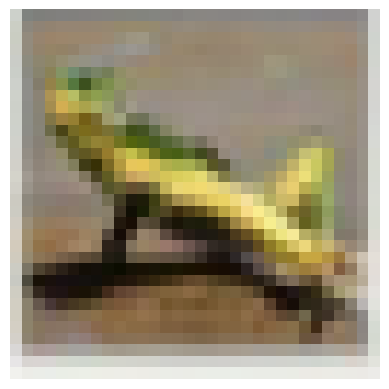

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Epoch 1/15
94/94 [==============================] - 2s 16ms/step - loss: 1.4065 - accuracy: 0.5163
Epoch 2/15
94/94 [==============================] - 1s 11ms/step - loss: 0.7877 - accuracy: 0.7226
Epoch 3/15
94/94 [==============================] - 1s 11ms/step - loss: 0.6330 - accuracy: 0.7848
Epoch 4/15
94/94 [==============================] - 1s 11ms/step - loss: 0.5333 - accuracy: 0.8214
Epoch 5/15
94/94 [==============================] - 1s 11ms/step - loss: 0.4721 - accuracy: 0.8431
Epoch 6/15
94/94 [==============================] - 1s 11ms/step - loss: 0.4324 - accuracy: 0.8544
Epoch 7/15
94/94 [==============================] - 1s 11ms/step - loss: 0.3814 - accuracy: 0.8699
Epoch 8/15
94/94 [==============================] - 1s 11ms/step - loss: 0.3661 - accuracy: 0.8798
Epoch 9/15
94/94 [==============================] - 1s 11ms/step - loss: 0.3253 - accuracy: 0.8926
Epoch 10/15
94/94 [==============================] - 1s 11ms/step - loss: 0

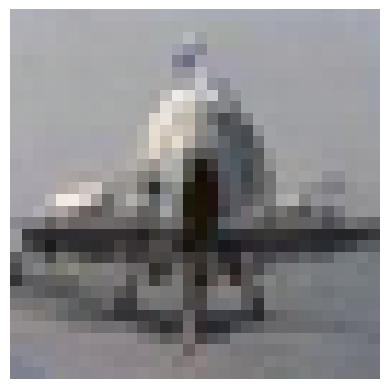

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Epoch 1/15
94/94 [==============================] - 1s 11ms/step - loss: 2.1157 - accuracy: 0.3533
Epoch 2/15
94/94 [==============================] - 1s 11ms/step - loss: 1.3761 - accuracy: 0.5373
Epoch 3/15
94/94 [==============================] - 1s 11ms/step - loss: 1.1825 - accuracy: 0.5936
Epoch 4/15
94/94 [==============================] - 1s 11ms/step - loss: 1.0328 - accuracy: 0.6526
Epoch 5/15
94/94 [==============================] - 1s 11ms/step - loss: 0.8923 - accuracy: 0.7009
Epoch 6/15
94/94 [==============================] - 1s 11ms/step - loss: 0.8210 - accuracy: 0.7202
Epoch 7/15
94/94 [==============================] - 1s 11ms/step - loss: 0.7493 - accuracy: 0.7504
Epoch 8/15
94/94 [==============================] - 1s 11ms/step - loss: 0.7056 - accuracy: 0.7624
Epoch 9/15
94/94 [==============================] - 1s 11ms/step - loss: 0.6364 - accuracy: 0.7873
Epoch 10/15
94/94 [==============================] - 1s 11ms/step - loss: 0

In [36]:
run(agent)

# Training analysis

In [37]:
def plot_history(data, title="Plot"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(data, label=title)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

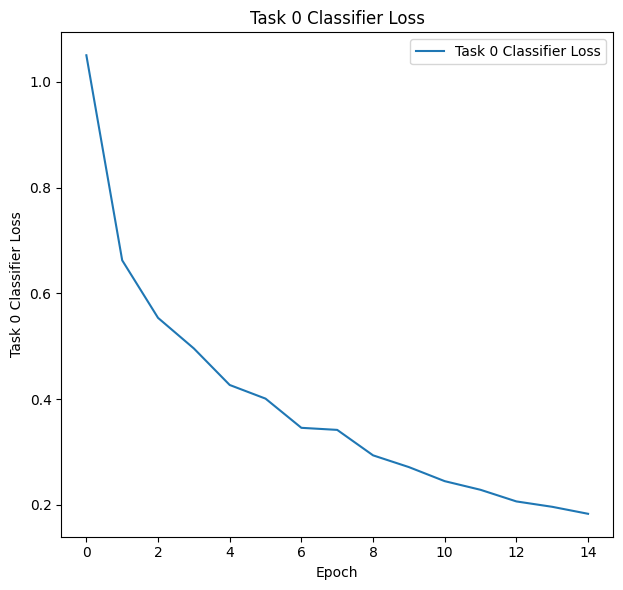

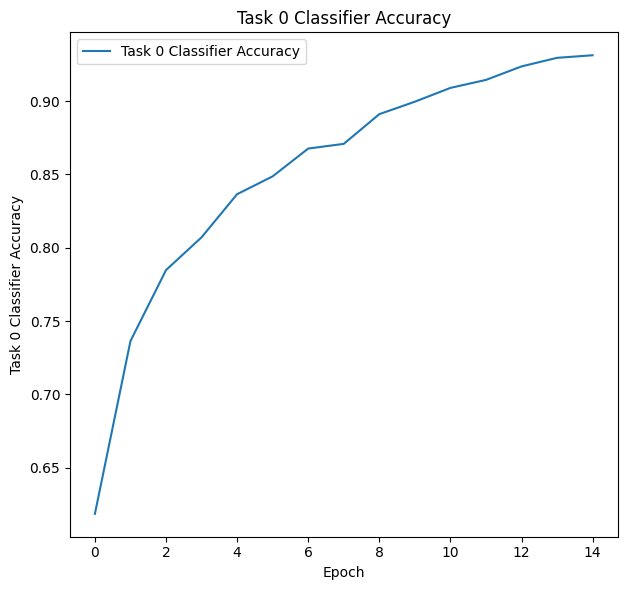

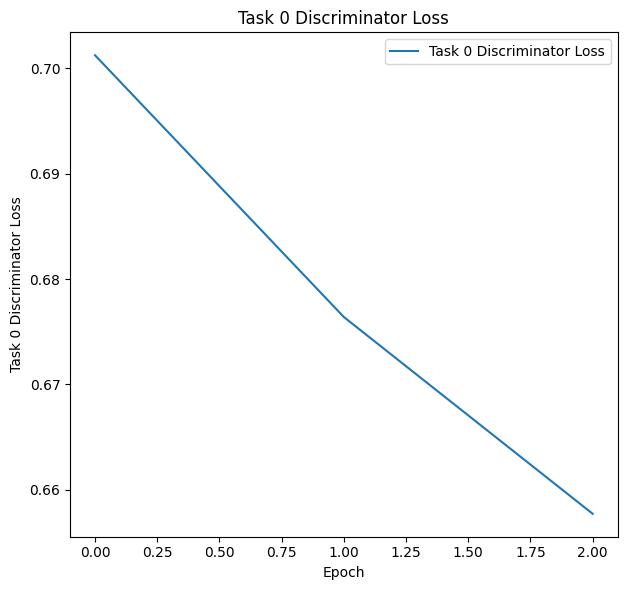

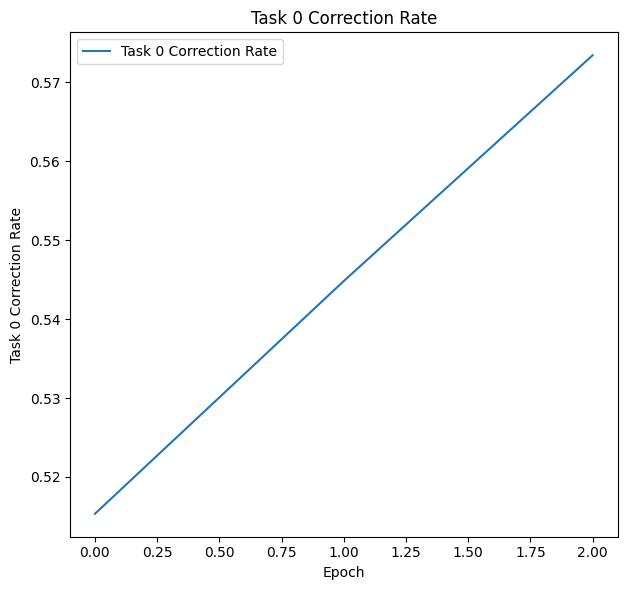

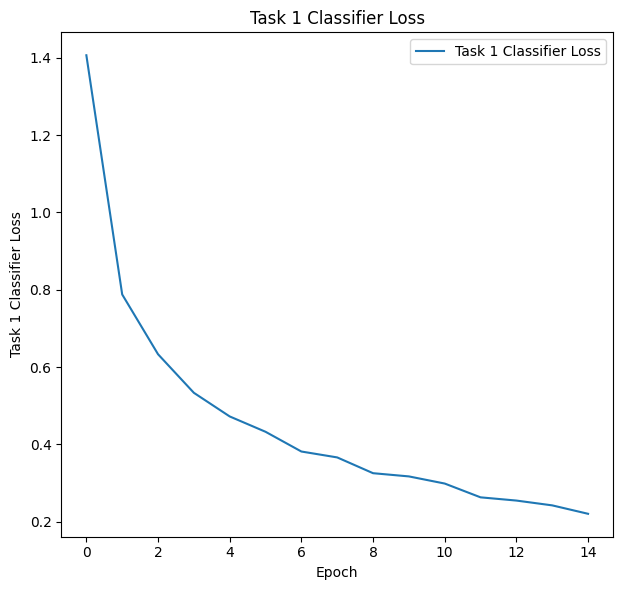

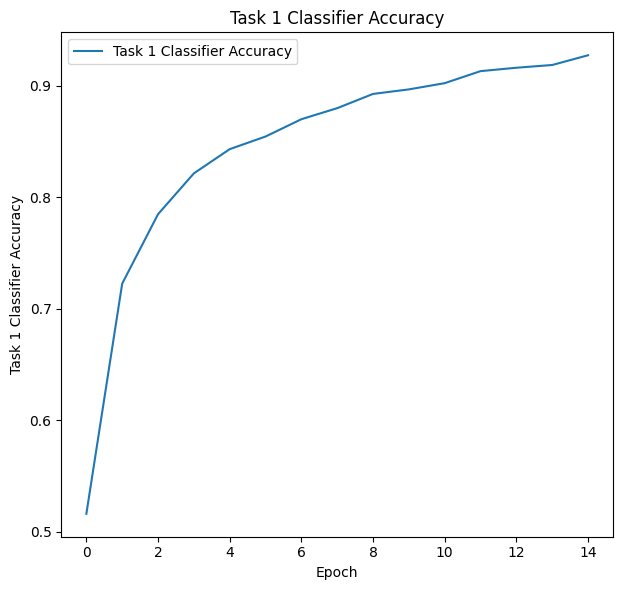

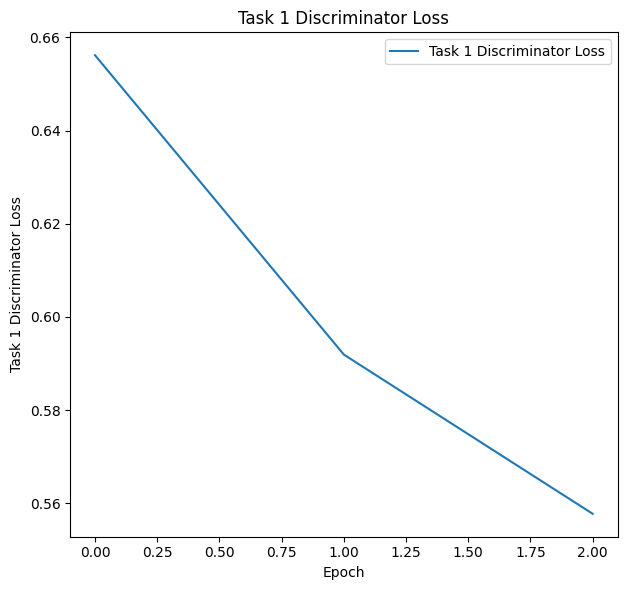

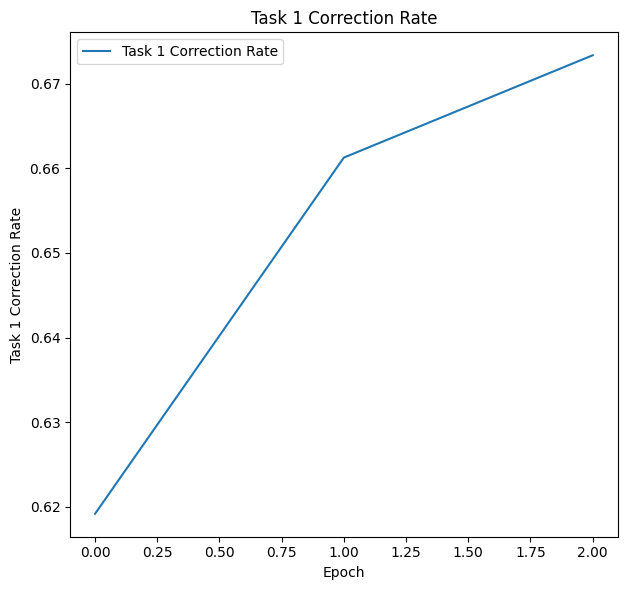

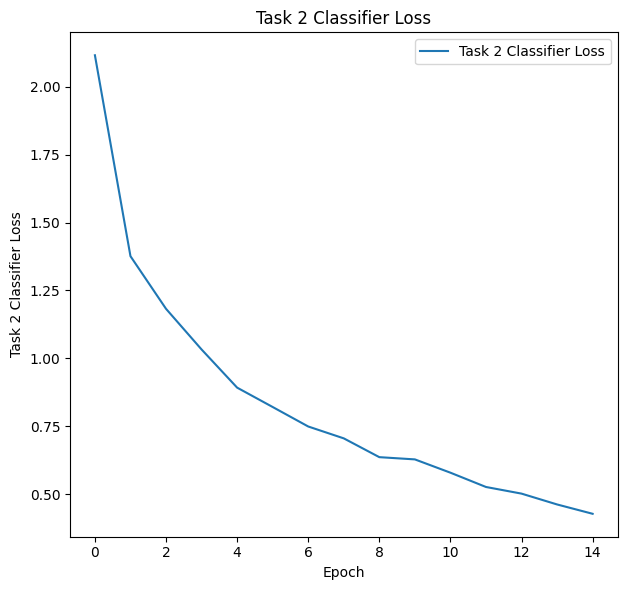

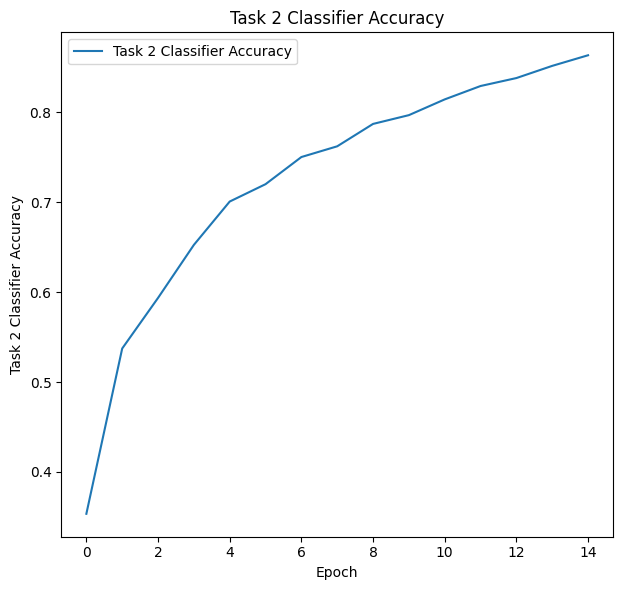

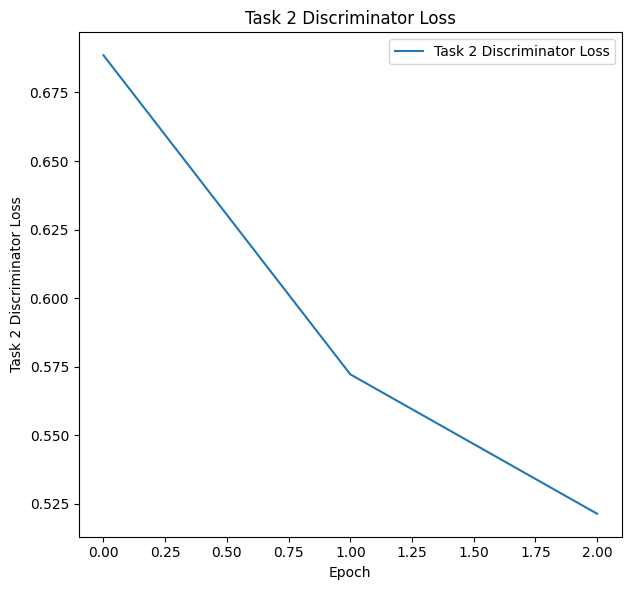

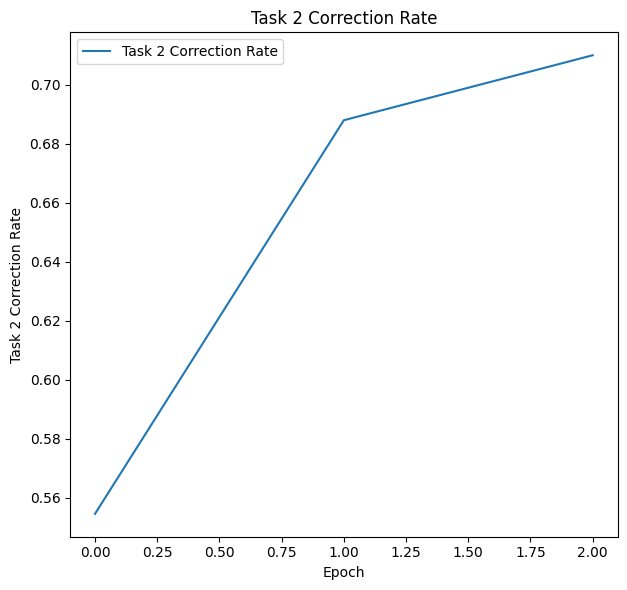

In [38]:
#analysis per task
for task in range(agent.params['n_tasks']):
    plot_history(agent.eval["cls_loss"][task], title=f"Task {task} Classifier Loss")
    plot_history(agent.eval["cls_acc"][task], title=f"Task {task} Classifier Accuracy")
    plot_history(agent.eval["discriminator_loss"][task], title=f"Task {task} Discriminator Loss")
    plot_history(agent.eval["correction_rate"][task], title=f"Task {task} Correction Rate")

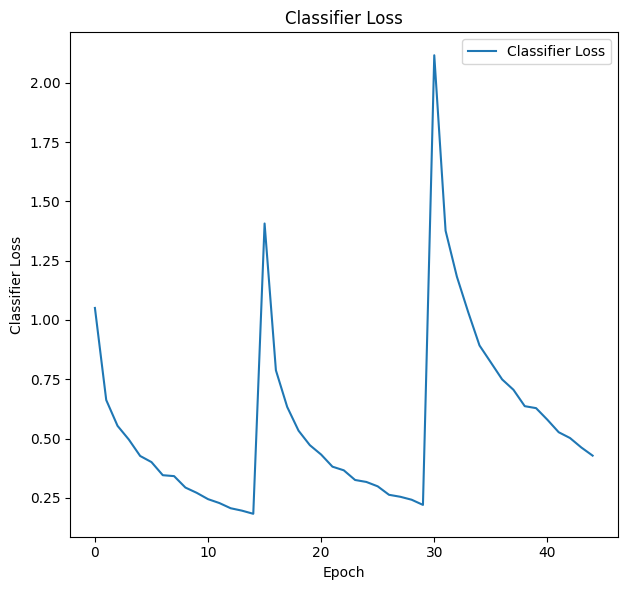

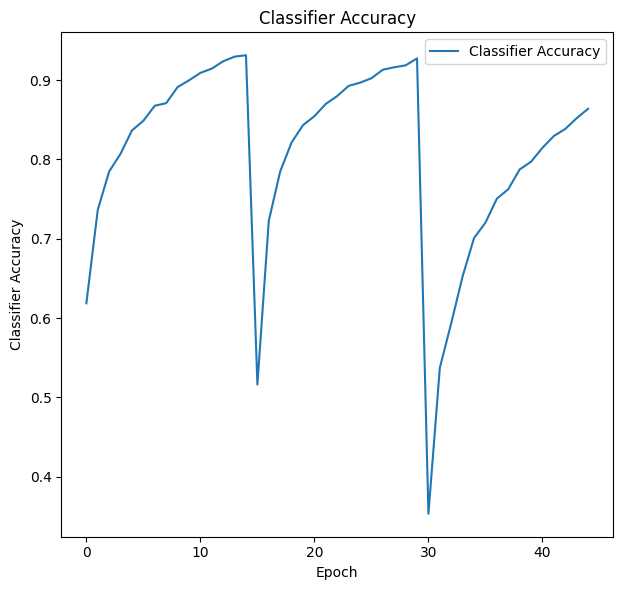

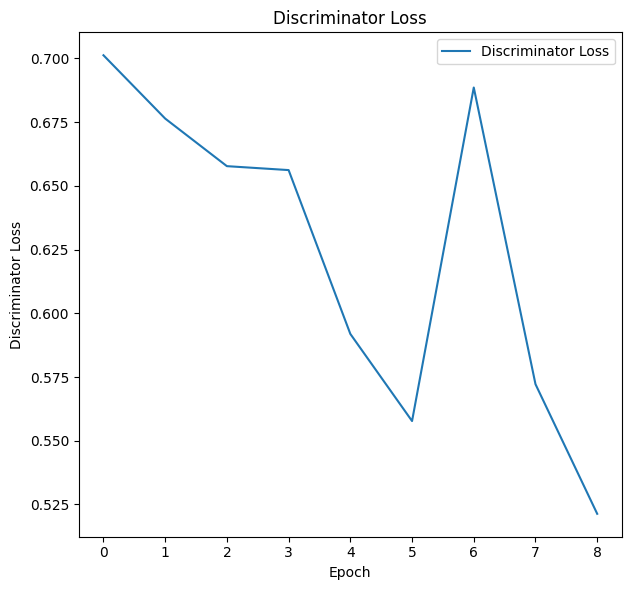

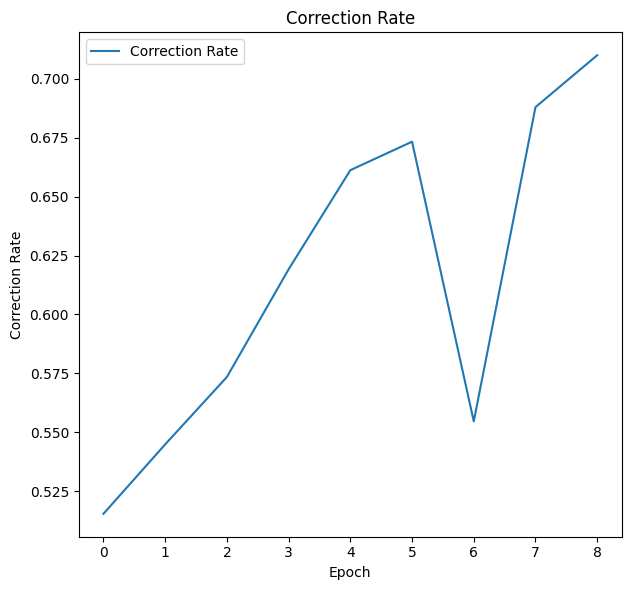

In [40]:
#full analysis
plot_history(np.concatenate(agent.eval["cls_loss"]), title=f"Classifier Loss")
plot_history(np.concatenate(agent.eval["cls_acc"]), title=f"Classifier Accuracy")
plot_history(np.concatenate(agent.eval["discriminator_loss"]), title=f"Discriminator Loss")
plot_history(np.concatenate(agent.eval["correction_rate"]), title=f"Correction Rate")

# Image generation

In [45]:
images = []
for i in range(10):
    images.append(generate(agent, 2, dg_weight_1st_order=1, dg_weight_2nd_order=0, boosting=1, class_idx=i))

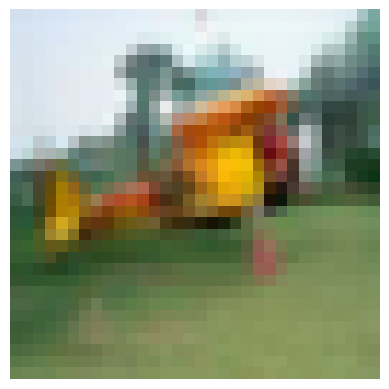

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


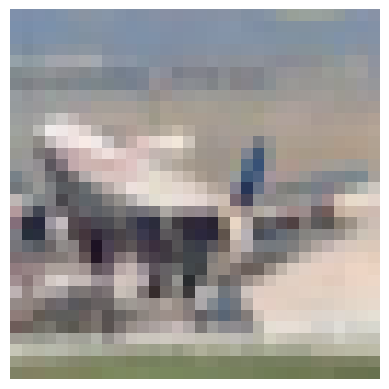

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


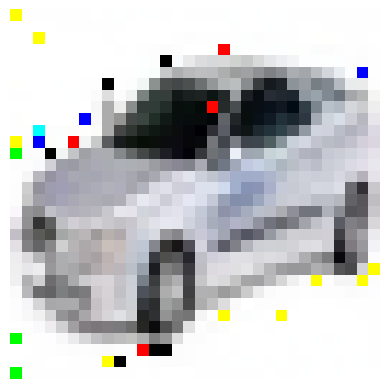

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


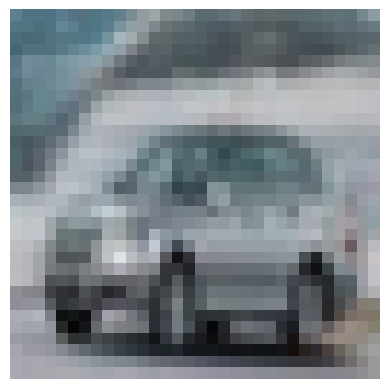

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


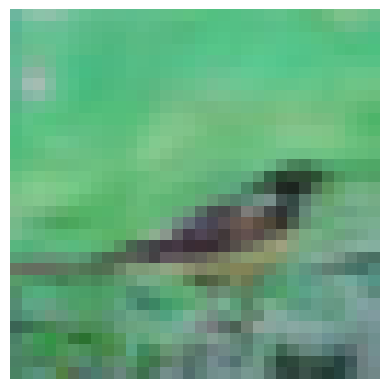

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


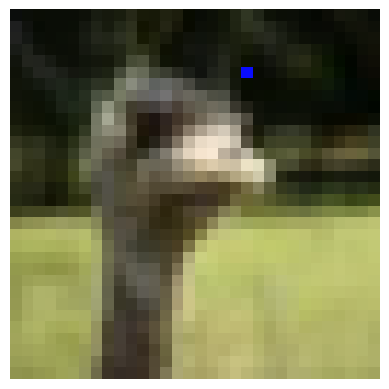

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


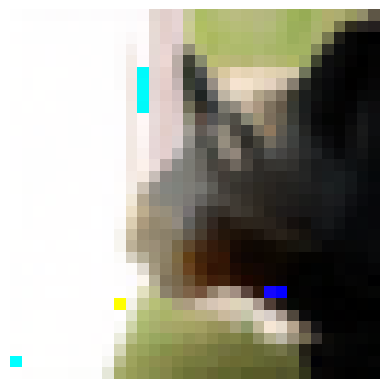

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


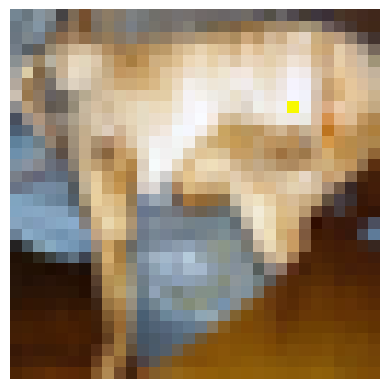

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


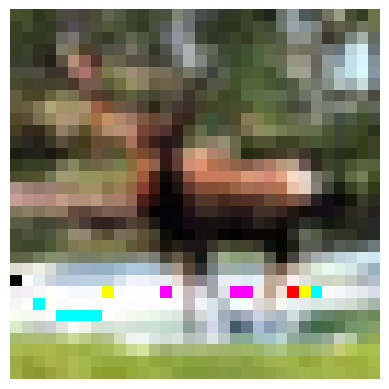

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


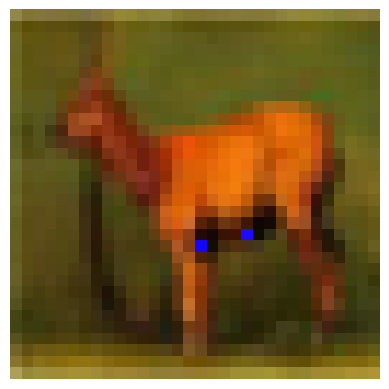

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


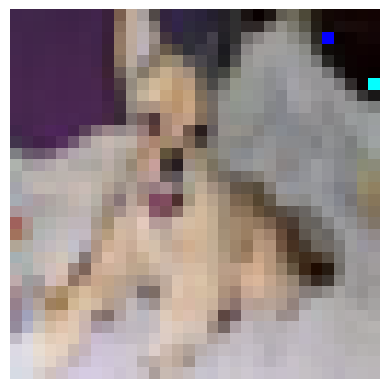

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


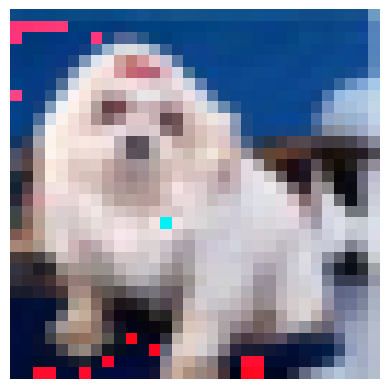

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


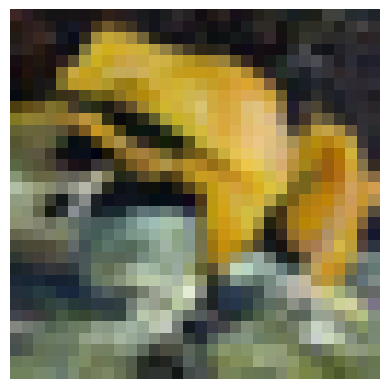

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


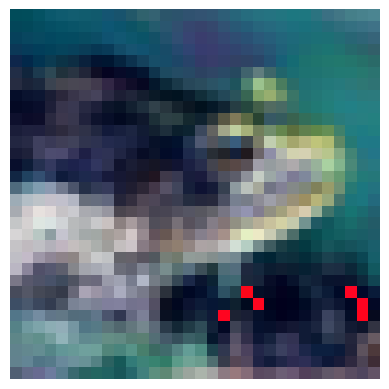

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


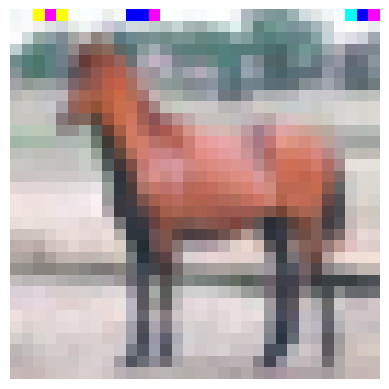

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


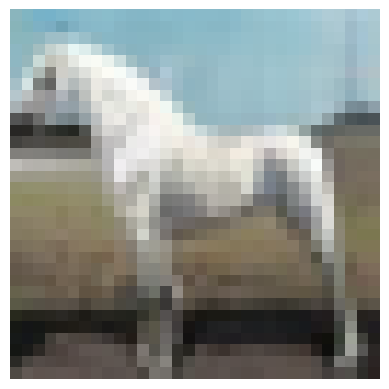

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


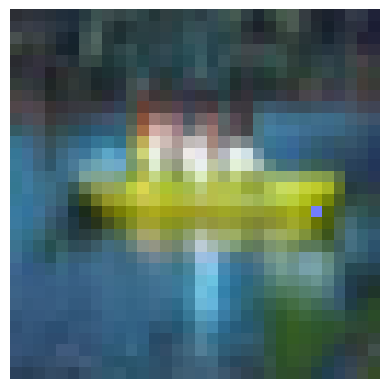

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


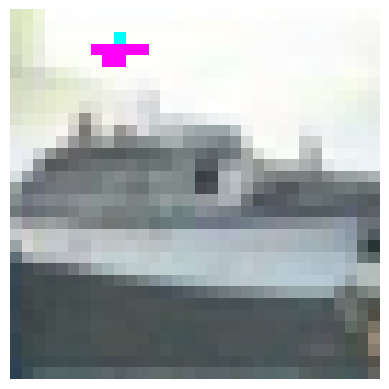

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


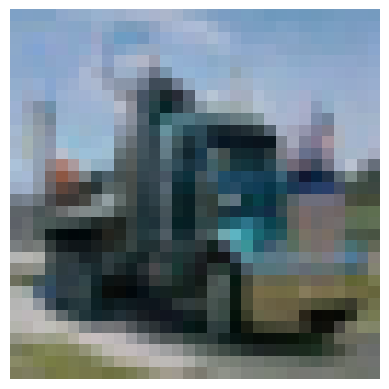

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


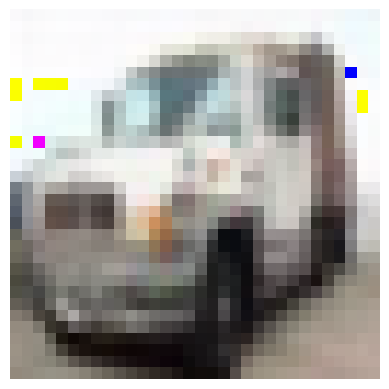

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [46]:
for image in images:
    disp(image[0][0])
    print(image[1][0])
    disp(image[0][1])
    print(image[1][1])

# Evaluation, testing

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from data_preparation import load_cifar_10

In [52]:
def confusion_matrix_plot(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [55]:
def evaluate(X_test, y_test, eval_name=""):
    y_pred = agent.classifier.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    print(f"Classification Report on {eval_name}:")
    print(classification_report(y_true_classes, y_pred_classes, zero_division=0))
    print(f"Confusion Matrix on {eval_name}:")
    confusion_matrix_plot(y_true_classes, y_pred_classes)
    print(f"Accuracy on {eval_name}: ", agent.score(y_true_classes, y_pred_classes))

In [53]:
def run_eval():
    (_, _), (X_test, Y_test) = load_cifar_10()
    evaluate(X_test, Y_test, eval_name="TEST SET")

    for task, (x_test, y_test) in enumerate(dpt_test):
        evaluate(x_test, y_test, eval_name=f"TASK {task}")

313/313 [==============================] - 1s 2ms/step
Classification Report on TEST SET:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1000
           1       0.97      0.79      0.87      1000
           2       0.56      0.58      0.57      1000
           3       0.40      0.56      0.47      1000
           4       0.59      0.76      0.67      1000
           5       0.61      0.69      0.65      1000
           6       0.00      0.00      0.00      1000
           7       0.68      0.89      0.77      1000
           8       0.84      0.92      0.87      1000
           9       0.77      0.93      0.85      1000

    accuracy                           0.68     10000
   macro avg       0.63      0.68      0.64     10000
weighted avg       0.63      0.68      0.64     10000

Confusion Matrix on TEST SET:


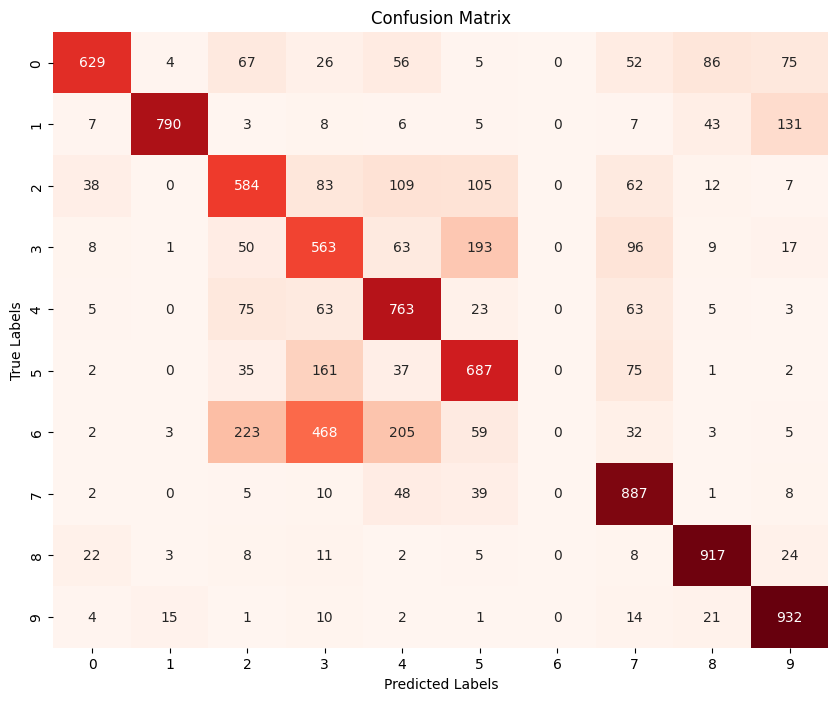

Accuracy on TEST SET:  0.6752
125/125 [==============================] - 0s 2ms/step
Classification Report on TASK 0:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1000
           1       0.99      0.79      0.88      1000
           2       0.83      0.58      0.69      1000
           3       0.83      0.56      0.67      1000
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.64      4000
   macro avg       0.40      0.29      0.33      4000
weighted avg       0.89      0.64      0.75      4000

Confusion Matrix on TASK 0:


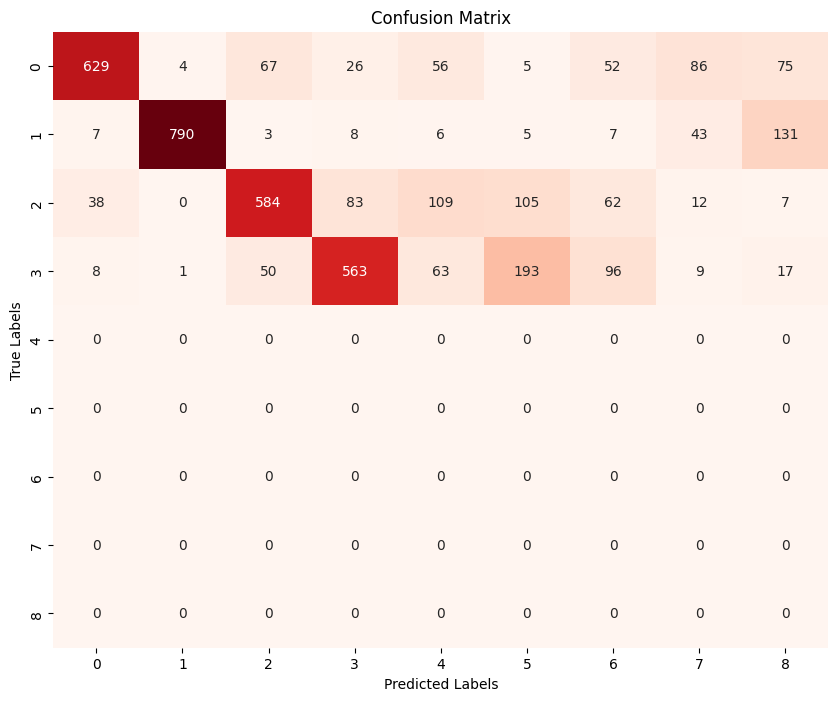

Accuracy on TASK 0:  0.6415
94/94 [==============================] - 0s 2ms/step
Classification Report on TASK 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.76      0.76      0.76      1000
           5       0.89      0.69      0.78      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.48      3000
   macro avg       0.17      0.15      0.15      3000
weighted avg       0.55      0.48      0.51      3000

Confusion Matrix on TASK 1:


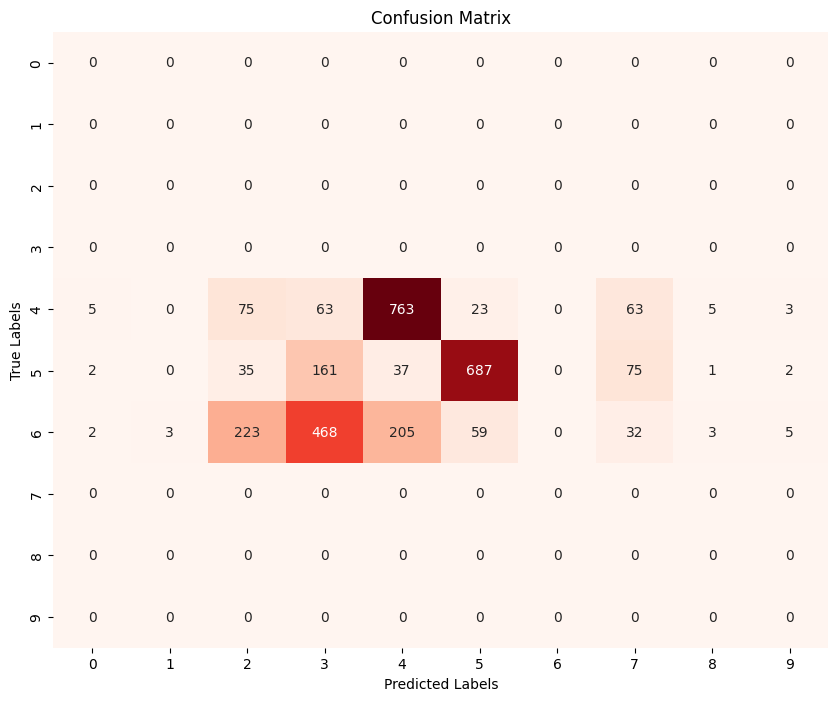

Accuracy on TASK 1:  0.48333333333333334
94/94 [==============================] - 0s 2ms/step
Classification Report on TASK 2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.98      0.89      0.93      1000
           8       0.98      0.92      0.95      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.91      3000
   macro avg       0.32      0.30      0.31      3000
weighted avg       0.97      0.91      0.94      3000

Confusion Matrix on TASK 2:


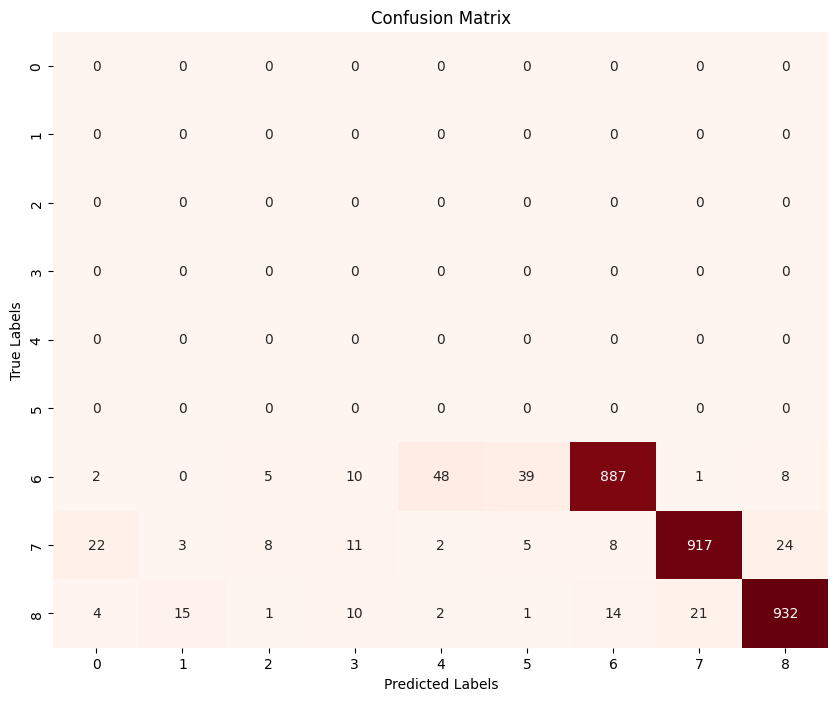

Accuracy on TASK 2:  0.912


In [56]:
run_eval()